In [1]:
import pandas as pd
import sys

sys.path.append("../..")
from digitalhistopathology.embeddings.image_embedding import ImageEmbedding

import anndata as ad
from umap import UMAP

2025-12-02 16:03:47.992397: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2025-12-02 16:03:47.992524: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2025-12-02 16:03:47.992532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [ ]:
optimal_HER2_model = "uni_full_koleo_16384_prototypes"

In [3]:
## recompute UMAP with these parameters

invasive_HER2_embedding_path = "../../results/HER2/pipeline/HER2_uni_full_koleo_16384_prototypes/invasive_image_embedding.h5ad"
emb = ad.read_h5ad(invasive_HER2_embedding_path)    

In [4]:
        
HER2_emb = ImageEmbedding(        
        pretrained_model=None,
        emb=emb,
        result_saving_folder="results",
        name="HER2",
    )

In [5]:
invasive_TNBC_embedding_path = "../../results/TNBC/pipeline/HER2_uni_full_koleo_16384_prototypes/invasive_image_embedding.h5ad"
emb = ad.read_h5ad(invasive_TNBC_embedding_path)    

TNBC_emb = ImageEmbedding(        
        pretrained_model=None,
        emb=emb,
        result_saving_folder="results",
        name="TNBC",
    )

In [6]:
# Let's add labels
labels_her2 = pd.read_csv("../../results/HER2/benchmark/uni_full_models/invasive_cancer_clustering/kmeans/uni_full_koleo_16384_prototypes/invasive_labels_5_clusters_umap_min_dist_0.001_n_neighbors_250.csv",
                          index_col=0)

In [7]:
HER2_emb.emb.obs.drop(["predicted_label"], axis=1, inplace=True)

In [8]:
HER2_emb.emb.obs = HER2_emb.emb.obs.merge(labels_her2[['predicted_label']], left_index=True, right_index=True)

# Perform knn classification from HER2 to TNBC raw embeddings

In [9]:
X_train = HER2_emb.emb.X
Y_train = HER2_emb.emb.obs["predicted_label"]

X_test = TNBC_emb.emb.X

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train, Y_train)
predicted_labels_TNBC = knn.predict(X_test)

In [10]:
palette={0: '#F9A11B', 
         1: '#31C4F3',
         2: '#ACB5B6', 
         3: '#EC2A90', 
         4: '#66BB46', 
         }
         

<Axes: title={'center': 'TNBC predicted labels distribution \n (from knn in the HER2 raw embedding space)'}>

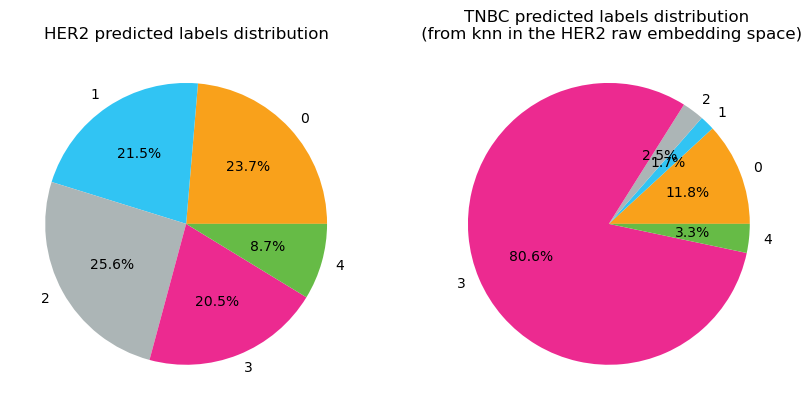

In [12]:
import matplotlib.pyplot as plt

# Pie charts to represent labels in HER2 and TNBC datasets
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
HER2_emb.emb.obs["predicted_label"].value_counts().sort_index().plot.pie(autopct='%1.1f%%', colors=palette.values(),
                                                                        title="HER2 predicted labels distribution",
                                                                        ylabel="")

plt.subplot(1, 2, 2)
pd.Series(predicted_labels_TNBC).value_counts().sort_index().plot.pie(autopct='%1.1f%%', colors=palette.values(),
                                                                        title=f"TNBC predicted labels distribution \n (from knn in the HER2 raw embedding space)",
                                                                        ylabel="")  

In [13]:
TNBC_emb.emb.obs["predicted_label_from_HER2_space"] = predicted_labels_TNBC

In [14]:
label = TNBC_emb.emb.obs[["predicted_label_from_HER2_space"]].rename(columns={"predicted_label_from_HER2_space": "predicted_label"})

In [15]:
label["label"] = ""

In [16]:
label.to_csv("../../results/transferability_exp/TNBC_predicted_labels_from_HER2_raw_space.csv")

In [17]:
## Check overalp with what we found using UMAP space

labels_UMAP = pd.read_csv("../../results/transferability_exp/TNBC_predicted_labels_from_HER2_space.csv", index_col=0)

In [20]:
from sklearn.metrics import adjusted_rand_score


adjusted_rand_score(labels_UMAP["predicted_label"], 
                    label["predicted_label"])

0.9303081928788585